In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import geopandas as gpd

## Grafici generici

In [2]:
dati = pd.read_csv('https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv')

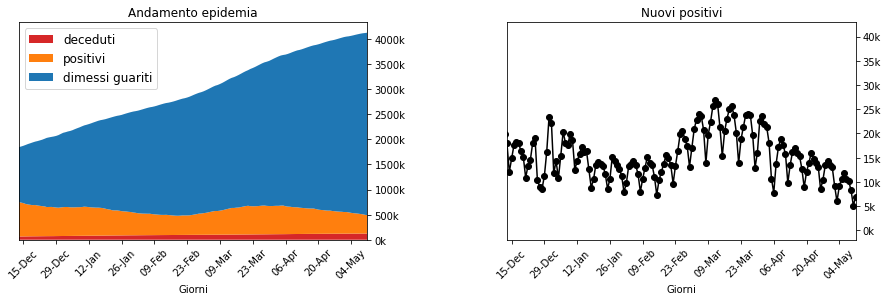

In [3]:
dates = np.array(list(map(lambda d: dt.datetime.fromisoformat(d).date(), dati["data"])))

fig, axes = plt.subplots(1, 2, figsize=(15, 4))
#ax = fig.add_axes([0.1, 0.2, 0.8, 0.9]) 
axes = axes.flatten()

BLUE = '#1f77b4'
YELLOW = '#ff7f0e'
RED = '#d62728'

for ax in axes:
    ax.tick_params('x', labelrotation=45)
    ax.yaxis.tick_right()

    ax.set_xlabel('Giorni')
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%dk"))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
    ax.xaxis.set_major_locator(mdates.WeekdayLocator( byweekday=dates[-1].weekday(),
                                                    interval= 3 if (dates[0].day - dates[-1].day) % 14 == 0 else 2))
    ax.set_xlim(dates[-150], dates[-1])
    
axes[0].stackplot(dates, dati['deceduti']/1000, dati['totale_positivi']/1000, dati['dimessi_guariti']/1000, colors=[RED, YELLOW, BLUE] , labels=['deceduti', 'positivi', 'dimessi guariti'])
axes[0].legend(loc='upper left', fontsize='large')
axes[0].set_title('Andamento epidemia', fontdict={'fontsize': '12'})

axes[1].plot(dates, dati['nuovi_positivi']/1000, label="nuovi casi", color="k", marker="o", linestyle="-")
axes[1].set_title('Nuovi positivi', fontdict={'fontsize': '12'})


plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

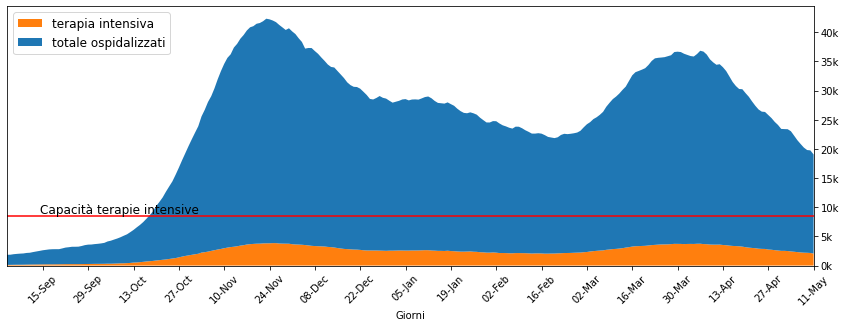

In [4]:
fig = plt.figure()
fig.set_size_inches(14, 4)
ax = fig.add_axes([0.1, 0.2, 0.8, 0.9]) 
plt.xticks(rotation=45)
ax.yaxis.tick_right()

ax.set_xlabel('Giorni')
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%dk"))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
ax.xaxis.set_major_locator(mdates.WeekdayLocator( byweekday=dates[-1].weekday(),
                                                interval= 3 if (dates[0].day - dates[-1].day) % 14 == 0 else 2))

plt.axhline(y=8490/1000, color='r')
ax.text(x=dates[-240], y=9000/1000, fontsize='large', s='Capacità terapie intensive')

ax.stackplot(dates, dati['terapia_intensiva']/1000, dati['totale_ospedalizzati']/1000,colors=[YELLOW, BLUE], labels = ['terapia intensiva', 'totale ospidalizzati'])
ax.set_xlim(dates[-250], dates[-1])
ax.legend(loc='upper left', fontsize='large')

plt.show()

## Nuovi Positivi
Il primo grafico mostra i nuovi positivi in relazione ai residenti nella regione.  
Il secondo mostra i nuovi positivi effettivi in ogni regione.  
I dati dei residenti nella regione provengono da [comuni-italiani.it](http://www.comuni-italiani.it/regioni.html) che a sua volta vengono dai dati ISTAT del 2019.  

In [5]:
# Caricamento dati regioni
covid_df = pd.read_csv('https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni-latest.csv')
covid_df = covid_df.replace(to_replace={'P.A. Bolzano': 'Trentino-Alto Adige', 'P.A. Trento': 'Trentino-Alto Adige', 
                                       'Friuli Venezia Giulia': 'Friuli-Venezia Giulia'}) \
                    .groupby('denominazione_regione', as_index=False) \
                    .sum(numeric_only=True)

# Caricamento della shape dell'Italia
fp = "datasets/italy shape/ITA_adm1.shp"
fp = "datasets/shape/dpc-covid-19-ita-aree.shp"
map_df = gpd.read_file(fp, driver='ESRI')
map_df = map_df.replace(to_replace={'Apulia': 'Puglia', 'Sicily': 'Sicilia'})

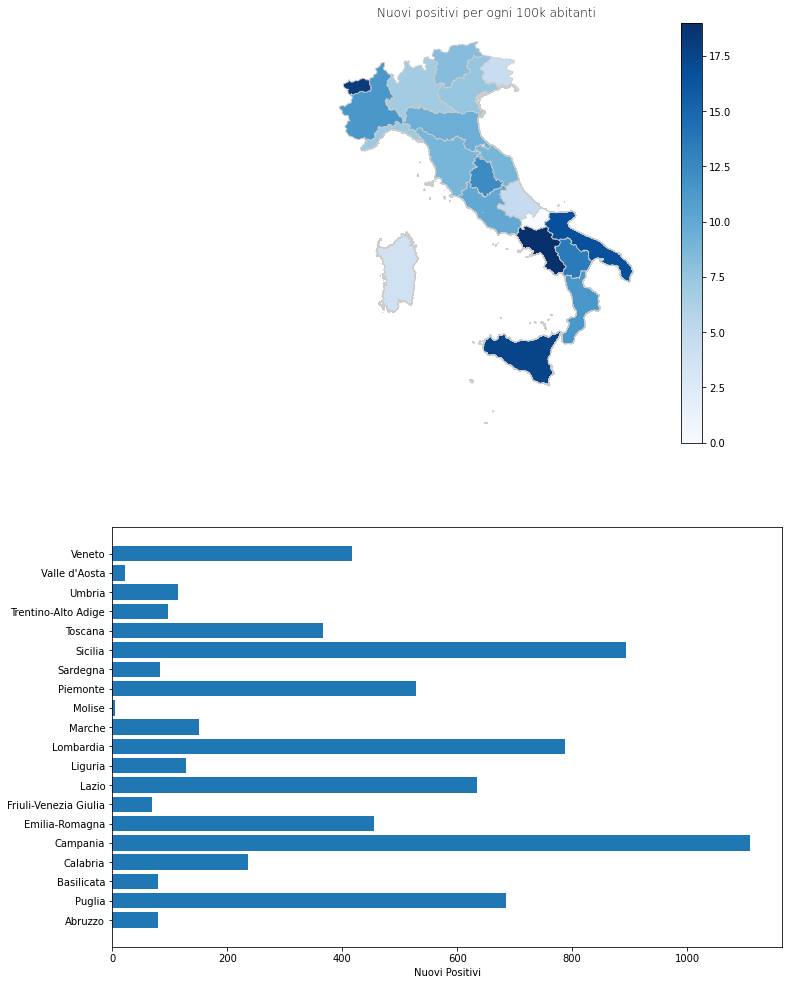

In [6]:
# Caricamento dati regioni
covid_df = pd.read_csv('https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni-latest.csv')
covid_df = covid_df.replace(to_replace={'P.A. Bolzano': 'Trentino-Alto Adige', 'P.A. Trento': 'Trentino-Alto Adige', 
                                       'Friuli Venezia Giulia': 'Friuli-Venezia Giulia'}) \
                    .groupby('denominazione_regione', as_index=False) \
                    .sum(numeric_only=True)

# Caricamento della shape dell'Italia
fp = "datasets/italy shape/ITA_adm1.shp"
map_df = gpd.read_file(fp)
map_df = map_df.replace(to_replace={'Apulia': 'Puglia', 'Sicily': 'Sicilia'})

# Caricamento dataset della popolazione italiana
popolazione = pd.read_csv('datasets/popolazione_italiana.csv', thousands='.')

# Unione dei tre dataset
merged = map_df.merge(covid_df, how='left', left_on="NAME_1", right_on="denominazione_regione") \
                .merge(popolazione, how='left', left_on="NAME_1", right_on='Regione')

# Tenere solo le colonne utili
merged = merged[[ 'Regione', 'nuovi_positivi', 'Residenti', 'geometry']]

# Normalizzazione dei nuovi positivi per ogni 100k abitanti
div = lambda x: x[0]*100000/x[1] if 0<(x[0]/x[1])<1 else 0
merged['nuovi_positivi_normalizzati'] = list(map(div, zip(merged['nuovi_positivi'], merged['Residenti']))) 

# Print figura
fig, ax = plt.subplots(2, figsize=(12, 17))
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=0, vmax=max(merged['nuovi_positivi_normalizzati'])))
fig.colorbar(sm, ax=ax[0], orientation='vertical')

ax[0].axis('off')
ax[0].set_title('Nuovi positivi per ogni 100k abitanti', fontdict={'fontsize': '12', 'fontweight' : '3'})

# create map
merged.plot(column='nuovi_positivi_normalizzati', cmap='Blues', linewidth=0.8, ax=ax[0], edgecolor='0.8')

ax[1].barh( merged.index.values, merged['nuovi_positivi'].values, label='nuovi positivi', tick_label=merged['Regione'])
ax[1].set_xlabel('Nuovi Positivi')

plt.show()
#plt.tight_layout()

## Tamponi 
Grafico che mostra l'efficienza dei tamponi giornalieri.  

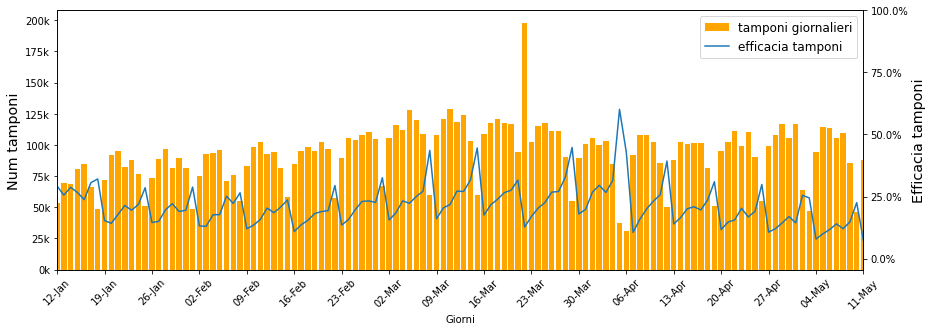

In [7]:
tamponi_giorno_precedente = dati['casi_testati'][0:-1]
delta_tamponi = dati['casi_testati'][1:].values - tamponi_giorno_precedente.values
delta_tamponi = np.array(list(map(lambda x:  x if x >= 0 and x <= 200_000 else delta_tamponi[100:].mean(), delta_tamponi))) # elimina gli outliner

percentages = [ str(x) + '%' for x in np.array([0.0, 25.0, 50.0, 75.0, 100.0])]

# percentuale nuovi_positivi/nuovi_tamponi
div = lambda x: x[0]/x[1] if 0<(x[0]/x[1])<1 else None
ratio_nuovi_pos_nuovi_tamp = list(map(div, list(zip(dati['nuovi_positivi'], delta_tamponi))))

fig = plt.figure()
fig.set_size_inches(14, 4)
ax = fig.add_axes([0.1, 0.2, 0.8, 0.9]) 
plt.xticks(rotation=45)
ax.yaxis.tick_right()


# double y axis
ax2 = ax.twinx()
line_positivi = ax2.plot(dates[1:], ratio_nuovi_pos_nuovi_tamp, label="efficacia tamponi")
ax.set_ylabel('Num tamponi',  fontsize='x-large')

ax2.set_yticks(np.arange(0, 1, step=0.20))
ax2.set_yticklabels(percentages)
ax2.set_ylabel('Efficacia tamponi', fontsize='x-large')


ax.set_xlabel('Giorni')
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%dk"))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
ax.xaxis.set_major_locator(mdates.WeekdayLocator( byweekday=dates[-1].weekday(),
                                                interval= 1))

bar = ax.bar(dates[1:], delta_tamponi/1000, label='tamponi giornalieri', color="orange")
ax.set_xlim(dates[-120], dates[-1])
ax.legend(loc='upper left', fontsize='large')


arr = [bar]+line_positivi
labs = [a.get_label() for a in arr]
ax.legend(arr, labs, fontsize='large')

plt.show()